#  Autoencoders notebook

![](https://curiousily.com/static/239315188ad13ab0270f753fd899b536/629d2/autoencoder-architecture.png) [source](https://curiousily.com/static/239315188ad13ab0270f753fd899b536/629d2/autoencoder-architecture.png)

## Demo notebook :

We will test here autoencoders for anomaly detection on ECG5000

In [63]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Sequential, layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError

# visualisation
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
%matplotlib inline

In [64]:
df_raw = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = df_raw.values
df_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


We can see here that we have 140 point for each cardiogram and the last column is for label :
1 = ok and 0 = not ok

We will now start to clean and normalize the data :

In [65]:
# We get the labels
labels = raw_data[:, -1]

# The cardiogram data
data = raw_data[:, 0:-1]

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

In [66]:
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

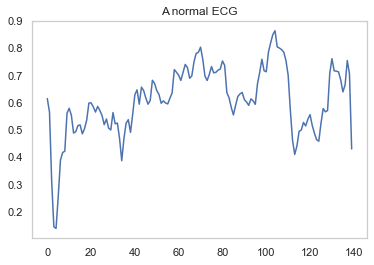

In [67]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[4])
plt.title("A normal ECG")
plt.show()

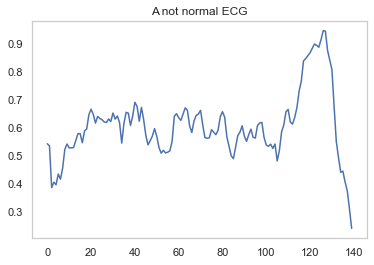

In [68]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("A not normal ECG")
plt.show()

In [69]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector,self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(140, activation="sigmoid")
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [70]:
autoencoder.compile(optimizer='adam', loss='mae')

Epoch 1/200
5/5 [==============================] - 0s 30ms/step - loss: 0.1429 - val_loss: 0.1451
Epoch 2/200
5/5 [==============================] - 0s 9ms/step - loss: 0.1361 - val_loss: 0.1414
Epoch 3/200
5/5 [==============================] - 0s 8ms/step - loss: 0.1316 - val_loss: 0.1354
Epoch 4/200
5/5 [==============================] - 0s 8ms/step - loss: 0.1238 - val_loss: 0.1254
Epoch 5/200
5/5 [==============================] - 0s 10ms/step - loss: 0.1119 - val_loss: 0.1131
Epoch 6/200
5/5 [==============================] - 0s 10ms/step - loss: 0.0984 - val_loss: 0.1012
Epoch 7/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0838 - val_loss: 0.0899
Epoch 8/200
5/5 [==============================] - 0s 9ms/step - loss: 0.0708 - val_loss: 0.0830
Epoch 9/200
5/5 [==============================] - 0s 9ms/step - loss: 0.0621 - val_loss: 0.0791
Epoch 10/200
5/5 [==============================] - 0s 9ms/step - loss: 0.0559 - val_loss: 0.0767
Epoch 11/200
5/5 [========

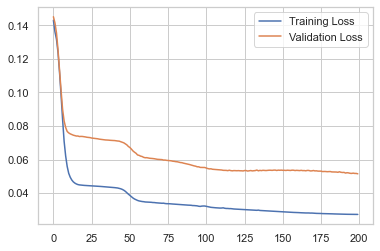

In [71]:
history = autoencoder.fit(normal_train_data, normal_train_data,
epochs=200,
batch_size=512,
validation_data=(test_data, test_data),
shuffle=True)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

### Let's see how our autoencoder reconstruct the data when it is normal :

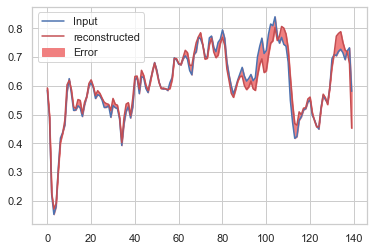

In [72]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()


sample_nb = 55

plt.plot(normal_test_data[sample_nb], 'b')
plt.plot(decoded_data[sample_nb], 'r')
plt.fill_between(np.arange(140), decoded_data[sample_nb], normal_test_data[sample_nb], color='lightcoral')
plt.legend(labels=["Input", "reconstructed", 'Error'])
plt.show()

### Let's see now how it does when the data is anormal :

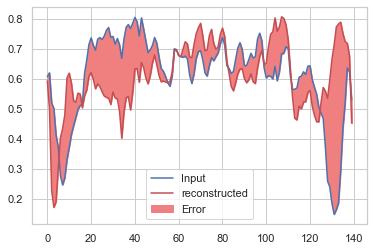

In [73]:
sample_nb = 55

plt.plot(anomalous_test_data[sample_nb], 'b')
plt.plot(decoded_data[sample_nb], 'r')
plt.fill_between(np.arange(140), decoded_data[sample_nb], anomalous_test_data[sample_nb], color='lightcoral')
plt.legend(labels=["Input", "reconstructed", 'Error'])
plt.show()

## Anomalies detection

So we saw that when the input is an anomaly, the reconstruction error will be greater than normal, let's detect errors when the mae is greater than some threshold

## Attack plan :

First, we need to find the threshold, so let's find the average of the error in the normal dataset

then use this threshold to categorate errors.

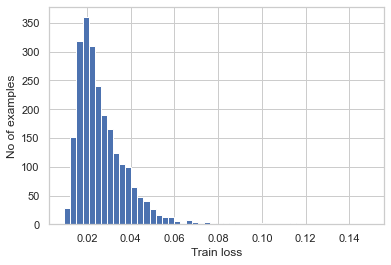

In [74]:
reconstruction = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstruction, normal_train_data)

plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [75]:
# Get the threshold :

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.040307388


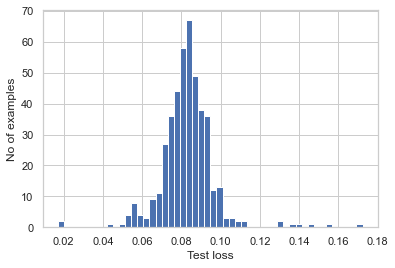

In [76]:
# Let's plot the error when there is anomalies
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [77]:
def predict(model, data, threshold):
    """This function, will take the data then get the reconstruction from the model and process the error.
    If it is greater than the threshold ==> this is not normal !    
    """
    reconstruction = model(data)
    loss = tf.keras.losses.mae(reconstruction, data)
    return tf.math.less(loss, threshold)

In [78]:
def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [79]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.934
Precision = 0.9959839357429718
Recall = 0.8857142857142857


# Ressources :

## Some links :

[interactive example](https://anomagram.fastforwardlabs.com/#/)
<br />
Real-world use case :
[Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html)
<br />
[blog post](https://blog.keras.io/building-autoencoders-in-keras.html)
<br />
More details :
[Deep Learning](https://www.deeplearningbook.org/)